In [2]:
import pandas as pd

In [3]:
from pathlib import Path
path = Path.cwd()
data_path = path.parent
data_path = str(data_path)

In [14]:
df = pd.read_csv(data_path +'/data/dataset_darae.csv')
df.drop('입출차시각',axis =1,inplace= True)
df.drop('초',axis =1,inplace= True)
df.drop('Unnamed: 0',axis =1,inplace= True)
df.reset_index(inplace=True)

In [15]:
def parking(x):
    if x =='15동':
        return 15
    elif x == '14동':
        return 14
    elif x == '13동':
        return 13
    elif x == '12동':
        return 12
df['주차장'] = df['주차장'].apply(parking)

In [16]:
import optuna
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error
from lightgbm import LGBMRegressor
from datetime import datetime
from sklearn.model_selection import train_test_split

In [17]:
# # 일자별로 train_test 나누기
# train_data = df[df['일']<=25]
# test_data = df[df['일']>25]


#랜덤하게 나누기
train_data, test_data = train_test_split( df, test_size=0.33, random_state=42)

In [18]:
X_train , y_train = train_data.iloc[: , 0:14], train_data['혼잡도']
X_test , y_test = test_data.iloc[: , 0:14], test_data['혼잡도']
X_train.head()

,index,연,월,일,시,분,공휴일,요일,주차장,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm)
4692,4692,2022,9,5,7,55,0,0,13,22.6,0.5,0.1,96.0,0.0
14147,14147,2022,9,29,8,59,0,3,15,15.9,0.0,0.8,95.0,0.0
6857,6857,2022,9,26,8,1,0,0,13,16.3,0.0,0.3,83.0,0.0
13076,13076,2022,9,14,8,21,0,2,15,22.2,0.0,1.3,54.0,0.0
1224,1224,2022,9,8,8,57,0,3,12,18.0,0.0,0.7,81.0,0.0


In [19]:
model = LGBMClassifier()
model.fit(X_train, y_train, categorical_feature =['주차장'], verbose=100)

/Users/keumhyeonjun/opt/anaconda3/envs/행안부/lib/python3.9/site-packages/lightgbm/basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


LGBMClassifier()

In [20]:
y_predict = model.predict(X_test)
y_predict = pd.DataFrame(y_predict)

In [21]:
result = pd.concat([X_test,y_test],axis =1 ).reset_index()
result = pd.concat([result,y_predict],axis =1 )
result

,level_0,index,연,월,일,시,분,공휴일,요일,주차장,기온(°C),강수량(mm),풍속(m/s),습도(%),적설(cm),혼잡도,0
0,4720,4720,2022,9,5,8,9,0,0,13,22.8,2.4,0.2,96.0,0.0,1,1
1,5234,5234,2022,9,8,7,2,0,3,13,15.8,0.0,0.8,91.0,0.0,0,0
2,2085,2085,2022,9,16,9,0,0,4,12,24.2,0.0,2.8,71.0,0.0,3,3
3,9267,9267,2022,9,8,9,3,0,3,14,20.1,0.0,0.8,72.0,0.0,2,2
4,5369,5369,2022,9,8,8,59,0,3,13,18.0,0.0,0.7,81.0,0.0,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4696,8719,8719,2022,9,6,9,24,0,1,14,18.4,0.0,3.8,89.0,0.0,3,3
4697,10956,10956,2022,9,21,8,42,0,2,14,17.0,0.0,1.8,76.0,0.0,3,3
4698,440,440,2022,9,5,7,57,0,0,12,22.6,0.5,0.1,96.0,0.0,0,0
4699,12001,12001,2022,9,27,9,7,0,1,14,17.1,0.0,1.1,71.0,0.0,2,2


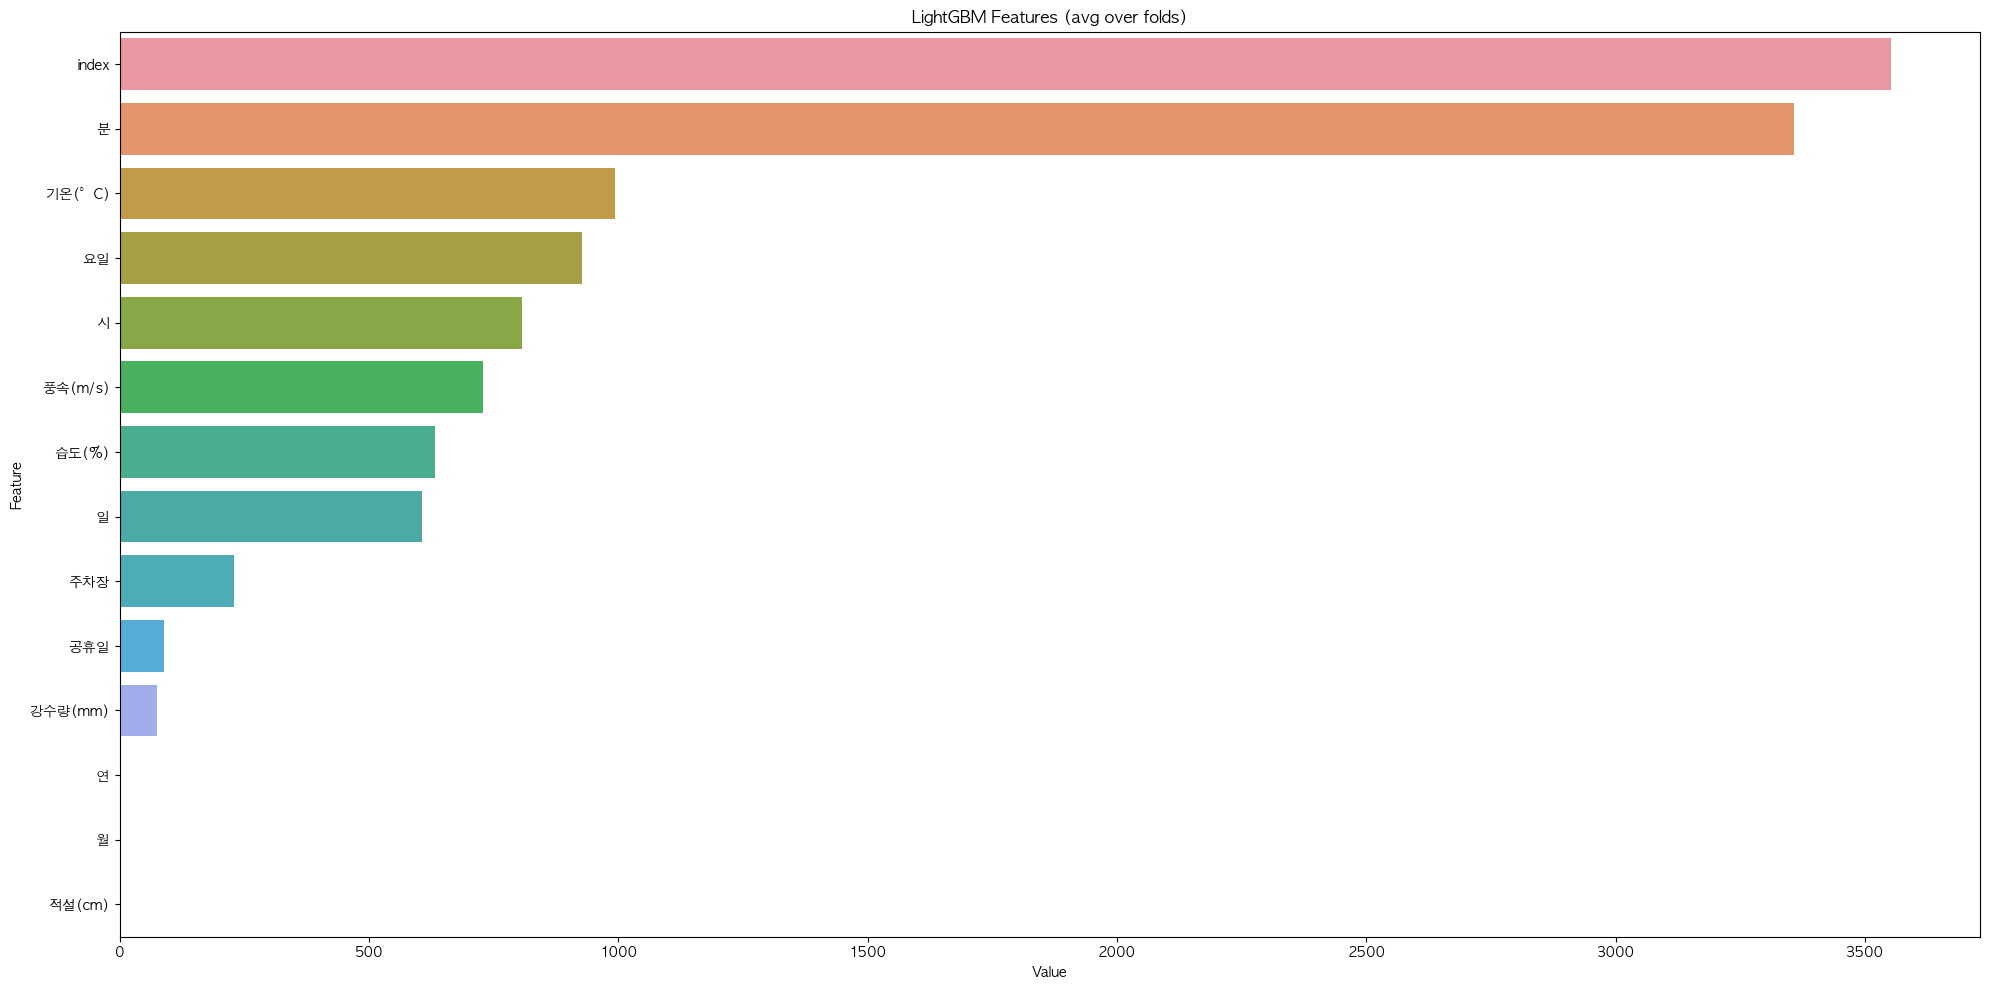

In [22]:
import matplotlib.pyplot as plt

plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False


import seaborn as sns
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# sorted(zip(clf.feature_importances_, X.columns), reverse=True)
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X_train.columns)), columns=['Value','Feature'])

plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
accuracy_score(result['혼잡도'], result[0])

0.967453733248245

In [24]:
result_15 = result[result['주차장']==15]
accuracy_score(result_15['혼잡도'], result_15[0])


0.9744680851063829

In [25]:
result_14 = result[result['주차장']==14]
accuracy_score(result_14['혼잡도'], result_14[0])


0.9721254355400697

In [26]:
result_13 = result[result['주차장']==13]
accuracy_score(result_13['혼잡도'], result_13[0])


0.9700374531835206

In [27]:
result_12 = result[result['주차장']==12]
accuracy_score(result_12['혼잡도'], result_12[0])


0.9576682859125607

In [28]:
import numpy as np
test = np.array([[4800, 2021, 8, 10, 9, 20, 0, 3, 13, 23,0,1,65,0]])
model.predict(test)

array([2])